# Support Vector Classifier Model on Breath Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
import itertools
import os
import pickle

In [2]:
audio_type = 'breath'
data_path = os.path.join('..', '..', 'data_struc', f'data_{audio_type}')

## Loading datasets

In [3]:
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))
val = pd.read_csv(os.path.join(data_path, 'valid.csv'))

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
val = val.loc[:, ~val.columns.str.contains('^Unnamed')]

train['target'] = train['target'].apply(lambda x: 1 if x == 'covid' else 0)
test['target'] = test['target'].apply(lambda x: 1 if x == 'covid' else 0)
val['target'] = val['target'].apply(lambda x: 1 if x == 'covid' else 0)

train.dropna(inplace=True)
test.dropna(inplace=True)
val.dropna(inplace=True)

# Appending validation to test, as we are using cross-validation anyway.
test = test.append(val, ignore_index=True)

train = shuffle(train, random_state=1)

In [4]:
covid, normal = 0, 0
for idx, row in train.iterrows():
    if(row['target'] == 1):
        covid += 1
    else:
        normal += 1

print(covid)
print(normal)

137
634


In [5]:
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_val = val.drop('target', axis=1)
y_val = val['target']

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Applying PCA

In [6]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_
explained_variance = [i * 100 for i in explained_variance]

In [7]:
cumulative_variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)

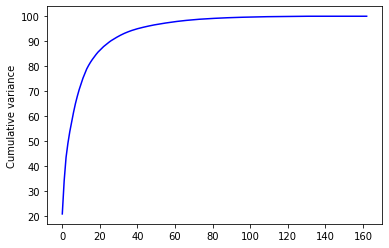

In [8]:
plt.ylabel('Cumulative variance')
plt.plot(cumulative_variance, color='b');

In [9]:
pca = PCA(n_components=20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## Training and Making Predictions


In [10]:
%%script echo "Comment line with %%script echo to run this cell."

# Hyperparameters chosen after repeatedly narrowing the range of values.
param_grid = {
    'C': [2, 3, 4, 5],
    'gamma': [0.0125, 0.015, 0.0175]
}

grid = GridSearchCV(
    SVC(probability=True), 
    param_grid, 
    refit = True, 
    cv=10, 
    n_jobs=-1,
    verbose=5
)

grid.fit(X_train, y_train) 

Comment line with %%script echo to run this cell.


In [11]:
%%script echo "Comment line with %%script echo to run this cell."

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

# Printing best cross-validation accuracy -- use this value and NOT test metrics to tune hyperparameters.
print(grid.best_score_)

Comment line with %%script echo to run this cell.


In [12]:
%%script echo "Comment line with %%script echo to run this cell."

with open('svc_breath.pickle', 'wb') as f:
    pickle.dump(grid, f)

Comment line with %%script echo to run this cell.


### Don't touch this section until hyperparameters have been tuned and finalized

Don't use test metrics as feedback to change hyperparameter, to avoid leakage from test set.

In [13]:
with open('svc_breath.pickle', 'rb') as f:
    model = pickle.load(f)

[[155   4]
 [  7  28]]
Accuracy:  0.9432989690721649
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       159
           1       0.88      0.80      0.84        35

    accuracy                           0.94       194
   macro avg       0.92      0.89      0.90       194
weighted avg       0.94      0.94      0.94       194



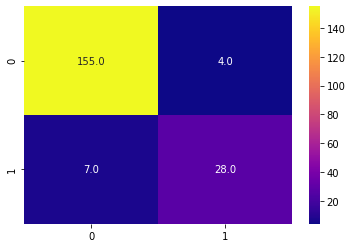

In [14]:
y_pred = model.predict(X_test) 

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'plasma', annot = True, fmt = ".1f")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))